***
# ONE WEEK GRAPH STUDY
***
The aim of this notebook is to look into a full week information from the GDELT dataset, and try to do type label propagation on it.

# LIBRARIES

In [1]:
import os
import os.path
os.chdir("C:/Users/maell/Fake_News_Project")

import urllib.request
import zipfile

import pandas as pd
import numpy as np
import community

from scipy import *

from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt

import networkx as nx

from tqdm import tqdm

from IPython.display import display #HTML plot of dataframe 

#plt.rcParams['figure.figsize'] = (20, 6)
#import seaborn as sns

#%matplotlib inline

# LOAD DATAFRAME

In [2]:
def open_data(fichier):
    data = pd.read_csv(fichier,sep = '\t',decimal = '.',index_col=0)
    return data

In [3]:
all_data_path='1_week_all_data_from_20180623_to_20180630'
df_all_data=open_data(all_data_path);

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
df_all_data.head()

,GlobalEventID,EventTimeDate,MentionTimeDate,MentionType,MentionSourceName,MentionIdentifier,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,InRawText,Confidence,MentionDocLen,MentionDocTone,MentionDocTranslationInfo,Extras
0,667330433.0,2.017062e+13,2.018062e+13,1.0,9news.com.au,https://www.9news.com.au/national/2018/06/22/1...,4.0,-1.0,2220.0,2249.0,1.0,80.0,3233.0,4.063604,NaN,NaN
1,667332152.0,2.017062e+13,2.018062e+13,1.0,lasalle.edu,https://www.lasalle.edu/blog/2018/06/22/la-sal...,5.0,-1.0,462.0,477.0,1.0,100.0,1273.0,5.309735,NaN,NaN
2,766498492.0,2.018062e+13,2.018062e+13,1.0,irishexaminer.com,https://www.irishexaminer.com/breakingnews/vie...,25.0,-1.0,7867.0,7859.0,0.0,20.0,15858.0,-5.619266,NaN,NaN
3,766498493.0,2.018062e+13,2.018062e+13,1.0,centralmaine.com,https://www.centralmaine.com/2018/06/22/usda-t...,5.0,-1.0,2209.0,2193.0,0.0,40.0,4916.0,0.000000,NaN,NaN
4,766498494.0,2.018062e+13,2.018062e+13,1.0,chronicle.co.zw,http://www.chronicle.co.zw/ed-recounts-poisoni...,5.0,1078.0,-1.0,1101.0,0.0,20.0,3716.0,-0.768049,NaN,NaN


# CHOSE THE CRITERIA FOR LIGHT GRAPH

In [4]:
x=[] # nombre de website qui publient sur l'evenement
pbar = tqdm(total=len(df_all_data.GlobalEventID.unique()))

for event in df_all_data.GlobalEventID.unique():
    x.append(len(df_all_data[df_all_data.GlobalEventID==event]))
    pbar.update(1)
    
pbar.close()

100%|█████████████████████████████████████████████████████████████████████| 1358027/1358027 [3:22:35<00:00, 111.72it/s]


In [5]:
#np.save('histogramme_criteria_light_graph',x)

In [2]:
x=np.load('histogramme_criteria_light_graph.npy')

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)
import seaborn as sns

C:\Users\maell\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


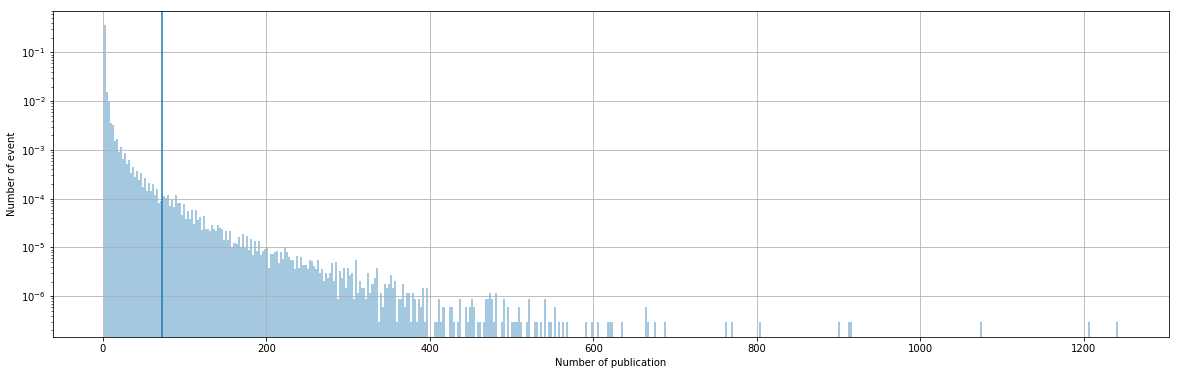

In [12]:
ax=sns.distplot(x,kde=False,norm_hist=True,bins=500)
ax.set_yscale('log')
plt.grid()
plt.xlabel("Number of publication")
plt.ylabel("Number of event")
plt.axvline(x=73)

Final choice : 73  
Aim :
- Remove enough logs to have a usable graph
- Keep only events that are not republished because newspapers that republish a lot do not advance us.

# EXTRACT ONLY KNOWN TYPE WEBSITE

In [4]:
def light_graph_sources_poids(all_data_path,critere):
# create a graph with sources as nodes, and edges weighted as the sources talks on the same event. 
# the heavier sources (that communicates with a lot of journals) are deleted
    data=open_data(all_data_path)
    G=nx.Graph()
    pbar = tqdm(total=len(data.GlobalEventID.unique()))
    
    
    for event in data.GlobalEventID.unique():
        liste_source=data[data.GlobalEventID==event].MentionSourceName
        if (len(liste_source)<critere):
            for comb in combinations(liste_source,2):
                if comb[0]!=comb[1]:
                    # deal with node creation
                    if not G.has_node(comb[0]):
                        G.add_node(comb[0])
                    if not G.has_node(comb[1]):
                        G.add_node(comb[1])
                    # deal with edge creation
                    if G.has_edge(comb[0],comb[1]):
                        G[comb[0]][comb[1]]['weight'] += 1
                    else:
                        G.add_edge(comb[0], comb[1], weight=1)
        pbar.update(1)
        
    pbar.close()
    return(G)
###############################################################################################################
def cleaning_graph(H):
    G=nx.Graph.copy(H)
    
    # Deleting the nan
    list_source=list(G.nodes)
    for source in list_source:
        if type(source) is not str:
            G.remove_node(source)
    
    # Remove edges not weigted enough
    edges_to_remove = []
    for edge in G.edges():
        if G[edge[0]][edge[1]]['weight']<5:
            edges_to_remove.append(edge)
    if(edges_to_remove!=[]):
        G.remove_edges_from(edges_to_remove)

    # Delete non connected components
    composants=list(nx.connected_components(G))
    i=0;
    while i<len(composants):
        if len(composants[i])==1:
            composant_supp=list(composants[i])[0]
            G.remove_node(composant_supp)
        i=i+1     
    return G

##########################################################################################################################""
def label_controversial_website(G,string=None):
    fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
    fake_news_sources_df.set_index('url',inplace=True)
    fake_news_sources=list(fake_news_sources_df.index.unique())
    for node in list(G.nodes):
        if node in fake_news_sources:
            G.node[node]['Controversial Website']=fake_news_sources_df.loc[node].type
        else:
            if string==True:
                G.node[node]['Controversial Website']='None'
            else:
                G.node[node]['Controversial Website']=None
    return (G)

In [7]:
# load reference
fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())

# create the graph
G=light_graph_sources_poids(all_data_path,73)
G_clean=cleaning_graph(G);

# add type label
G_final=label_controversial_website(G,string=True)

#register the graph
nx.write_gexf(G_final,'light_graph_1_week_20180623_to_20180630.gexf')

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|█████████████████████████████████████████████████████████████████████| 1358027/1358027 [2:26:03<00:00, 154.97it/s]


NameError: name 'cleaning_graph' is not defined

In [11]:
G_clean=cleaning_graph(G);

# add type label
G_final=label_controversial_website(G,string=True)

#register the graph
nx.write_gexf(G_clean,'light_graph_1_week_20180623_to_20180630.gexf')

In [13]:
nx.write_gexf(G_final,'light_graph_1_week_20180623_to_20180630_with_labels.gexf')

# LABEL PROPAGATION

In [5]:
confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unknown','satire','hate','clickBait','clickbait','junksci','rumor',
                    'unreliable','state','controversial']

fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())

params=[confidence_type, controversial_type, fake_news_sources_df]

In [6]:
def label_propagation_controversial_website_total(G,critere,params,show_results=None,show_working=None,nb_retry=100):

    #Récupération des paramètres 
    [confidence_type, controversial_type, fake_news_sources_df]=params
    
    #Create labels of nodes
    G=label_controversial_website(G);
    
    #Create list know nodes and other nodes
    list_known_nodes=[]
    list_other_nodes=[]
    for node in list(G.nodes):
        if node in fake_news_sources:
            list_known_nodes.append(node)
        else:
            list_other_nodes.append(node)
    list_known_nodes=list(set(list_known_nodes))
    list_other_nodes=list(set(list_other_nodes))
    
    #Create train and test set
    total_set=list_known_nodes
    test_set=[]
    train_set=[]
    for i in range (0,len(total_set)):
        nb=np.random.randint(3)
        if nb==2:
            test_set.append(total_set[i])
            G.node[total_set[i]]['Controversial Website']=None #delete referency
        else:
            train_set.append(total_set[i])
            
    # Classification
    compteur=0;
    compteur_retry=0;

    test_set_qui_se_vide=test_set.copy()
    test_set_qui_se_vide += list_other_nodes
    
    while test_set_qui_se_vide!=[]:
        #On tire un point au hasard
        number_nodes=len(test_set_qui_se_vide)
        if number_nodes>1:
            node=test_set_qui_se_vide[random.randint(0,number_nodes-1)]
        else:
            node=test_set_qui_se_vide[0]
        
        #On regarde ses voisins
        list_node_neighbor=list(G.neighbors(node))
        
        controversial_weight=0;
        confidence_weight=0;
        for neighboor in list_node_neighbor:
            value=G.node[neighboor]['Controversial Website']
            if value in confidence_type:
                confidence_weight+=G.edges[node,neighboor]['weight']
            elif value in controversial_type:
                controversial_weight+=G.edges[node,neighboor]['weight']
            
        if confidence_weight==controversial_weight :
            compteur_retry+=1
            if show_working==True:
                print('Retry',compteur_retry)
            if compteur_retry>nb_retry:
                if show_working==True:
                    print('END')
                break
        else:
            if confidence_weight>critere*controversial_weight:
                G.node[node]['Controversial Website']='confidence'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
            elif controversial_weight>critere*confidence_weight:
                G.node[node]['Controversial Website']='controversial'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
                
    # Evaluation
    confidence_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(confidence_type)].index)
    controversial_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(controversial_type)].index)

    well_classified_confidence=0;
    well_classified_controversial=0;
    bad_classified=0;
    for node in test_set:
        if G.nodes[node]['Controversial Website'] in confidence_type and node in confidence_website:
            well_classified_confidence+=1
        elif G.nodes[node]['Controversial Website'] in controversial_type and node in controversial_website :
            well_classified_controversial+=1
        elif G.nodes[node]['label'] in test_set_qui_se_vide :
            test=0
        else:
            bad_classified+=1

    well_classified=well_classified_confidence+well_classified_controversial
    not_classified=len(test_set)-well_classified-bad_classified
    if show_results==True:
        print('Number of nodes to classified :',len(test_set))
        print('Number of nodes not classified :',not_classified,'-',100*(not_classified)/len(test_set),'%')
        print('Number of well classified nodes :',well_classified,'-',100*well_classified/len(test_set),'%')
        print('Number of bad classifed nodes :',bad_classified,'-',100*bad_classified/len(test_set),'%')
        
    # DF resultat
    df_resultat=pd.DataFrame(columns=['Reference','Found','WebsiteURL'])
    df_resultat.set_index('WebsiteURL',inplace=True)
    for node in test_set:
        df_resultat=df_resultat.append({'WebsiteURL':node, 'Reference':fake_news_sources_df.loc[node].type, 'Found':G.nodes[node]['Controversial Website']}, ignore_index=True)
        
    
    return(G, df_resultat, len(test_set),not_classified,well_classified_controversial,well_classified_confidence,bad_classified)

################################################################################################################################

def normalization_graph(G):
    for e in G.edges():
        (n1,n2)=e
        denum=np.sqrt(G.degree(n1))*sqrt(G.degree(n2))
        G.edges[e]['weight']=G.edges[e]['weight']/denum
    return G

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [16:43<00:00,  3.01s/it]


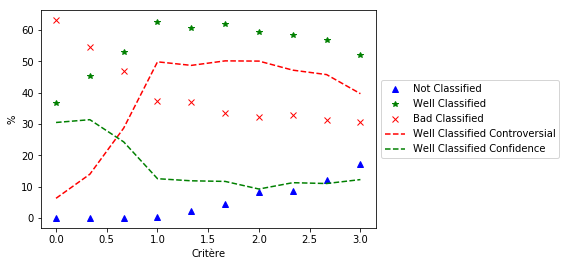

In [7]:
f= 40 #nb of folds
list_critere= np.linspace(0, 3, num=10) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)


################################################################################################################################

list_not_classified=[];
list_well_classified=[];
list_well_classified_controversial=[]
list_well_classified_confidence=[]
list_bad_classified=[];

file='light_graph_1_week_20180623_to_20180630.gexf'
G=nx.read_gexf(file)
G=normalization_graph(G);

pbar = tqdm(total=len(list_critere)*f)

for critere in list_critere:
    mean_not_classified=0
    mean_well_classified=0
    mean_bad_classified=0
    mean_well_classified_controversial=0;
    mean_well_classified_confidence=0;

    for i in range (0,f):
        #print('f=',i,'et critere=',critere)
        [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)

        mean_not_classified+=not_classified/to_classify
        mean_well_classified_controversial+=well_classified_controversial/to_classify
        mean_well_classified_confidence+=well_classified_confidence/to_classify
        mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
        mean_bad_classified+=bad_classified/to_classify
        
        pbar.update(1)

    list_not_classified.append(100*mean_not_classified/f)
    list_well_classified.append(100*mean_well_classified/f)
    list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
    list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
    list_bad_classified.append(100*mean_bad_classified/f)
    
    
pbar.close()

# plot graph
plt.figure()

plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
plt.xlabel('Critère')
plt.ylabel('%')

plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [07:07<00:00,  3.27s/it]


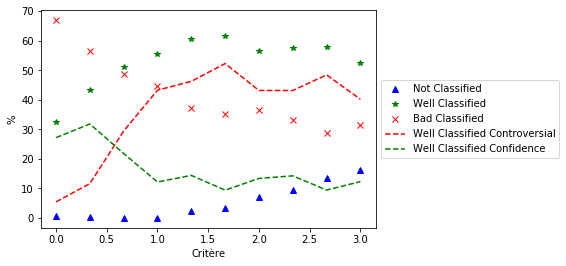

In [10]:
f= 15 #nb of folds
list_critere= np.linspace(0, 3, num=10) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)


################################################################################################################################

list_not_classified=[];
list_well_classified=[];
list_well_classified_controversial=[]
list_well_classified_confidence=[]
list_bad_classified=[];

file='light_graph_1_week_20180623_to_20180630.gexf'
G=nx.read_gexf(file)
G=normalization_graph(G);

pbar = tqdm(total=len(list_critere)*f)

for critere in list_critere:
    mean_not_classified=0
    mean_well_classified=0
    mean_bad_classified=0
    mean_well_classified_controversial=0;
    mean_well_classified_confidence=0;

    for i in range (0,f):
        #print('f=',i,'et critere=',critere)
        [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)

        mean_not_classified+=not_classified/to_classify
        mean_well_classified_controversial+=well_classified_controversial/to_classify
        mean_well_classified_confidence+=well_classified_confidence/to_classify
        mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
        mean_bad_classified+=bad_classified/to_classify
        
        pbar.update(1)

    list_not_classified.append(100*mean_not_classified/f)
    list_well_classified.append(100*mean_well_classified/f)
    list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
    list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
    list_bad_classified.append(100*mean_bad_classified/f)
    
    
pbar.close()

# plot graph
plt.figure()

plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
plt.xlabel('Critère')
plt.ylabel('%')

plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    Result due to 1 week data (probably not) or due to "light" graph (what does it change) ?
    We have seen that changing nb of day don't change anything -> the result is quite the same

# Comparaison with light graph for one day

Choice of the criteria

In [12]:
path='all_data/all_data_20170930.csv'
df_data=open_data(path)

In [14]:
x=[] # nombre de website qui publient sur l'evenement
pbar = tqdm(total=len(df_data.GlobalEventID.unique()))

for event in df_data.GlobalEventID.unique():
    x.append(len(df_data[df_data.GlobalEventID==event]))
    pbar.update(1)
    
pbar.close()

np.save('histogramme_criteria_light_graph_20170930',x)

100%|████████████████████████████████████████████████████████████████████████| 114938/114938 [01:30<00:00, 1265.63it/s]


C:\Users\maell\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


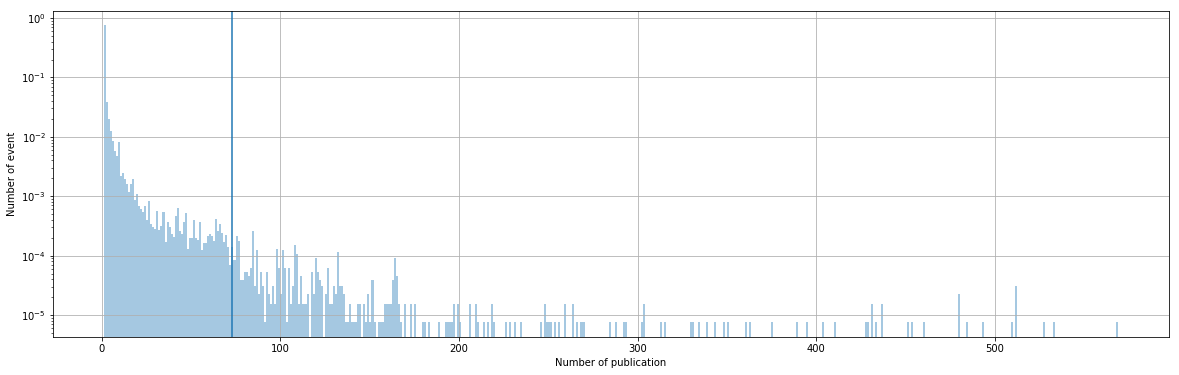

In [17]:
ax=sns.distplot(x,kde=False,norm_hist=True,bins=500)
ax.set_yscale('log')
plt.grid()
plt.xlabel("Number of publication")
plt.ylabel("Number of event")
plt.axvline(x=73)

Creation of the light graph

In [18]:
# create the graph
G=light_graph_sources_poids(path,73)
G_clean=cleaning_graph(G);

#register the graph
nx.write_gexf(G_clean,'light_graph_20170930.gexf')

100%|█████████████████████████████████████████████████████████████████████████| 114938/114938 [02:13<00:00, 858.72it/s]


Application of type propagation

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [01:14<00:00,  1.83it/s]


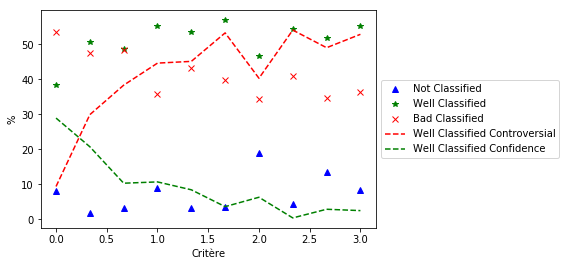

In [9]:
f= 15 #nb of folds
list_critere= np.linspace(0, 3, num=10) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)


################################################################################################################################

list_not_classified=[];
list_well_classified=[];
list_well_classified_controversial=[]
list_well_classified_confidence=[]
list_bad_classified=[];

file='light_graph_20170930.gexf'
G=nx.read_gexf(file)
G=normalization_graph(G);

pbar = tqdm(total=len(list_critere)*f)

for critere in list_critere:
    mean_not_classified=0
    mean_well_classified=0
    mean_bad_classified=0
    mean_well_classified_controversial=0;
    mean_well_classified_confidence=0;

    for i in range (0,f):
        #print('f=',i,'et critere=',critere)
        [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)

        mean_not_classified+=not_classified/to_classify
        mean_well_classified_controversial+=well_classified_controversial/to_classify
        mean_well_classified_confidence+=well_classified_confidence/to_classify
        mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
        mean_bad_classified+=bad_classified/to_classify
        
        pbar.update(1)

    list_not_classified.append(100*mean_not_classified/f)
    list_well_classified.append(100*mean_well_classified/f)
    list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
    list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
    list_bad_classified.append(100*mean_bad_classified/f)
    
    
pbar.close()

# plot graph
plt.figure()

plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
plt.xlabel('Critère')
plt.ylabel('%')

plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    Conclusion :

    Prendre que les "petit" revient au meme MAIS plus rapide !
    Bonne approximation !

# Try to found the "fall down" criteria for light graph propagation

In [14]:
df_data=open_data('1_week_all_data_from_20180623_to_20180630')
df_data.head()

,GlobalEventID,EventTimeDate,MentionTimeDate,MentionType,MentionSourceName,MentionIdentifier,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,InRawText,Confidence,MentionDocLen,MentionDocTone,MentionDocTranslationInfo,Extras
0,667330433.0,2.017062e+13,2.018062e+13,1.0,9news.com.au,https://www.9news.com.au/national/2018/06/22/1...,4.0,-1.0,2220.0,2249.0,1.0,80.0,3233.0,4.063604,NaN,NaN
1,667332152.0,2.017062e+13,2.018062e+13,1.0,lasalle.edu,https://www.lasalle.edu/blog/2018/06/22/la-sal...,5.0,-1.0,462.0,477.0,1.0,100.0,1273.0,5.309735,NaN,NaN
2,766498492.0,2.018062e+13,2.018062e+13,1.0,irishexaminer.com,https://www.irishexaminer.com/breakingnews/vie...,25.0,-1.0,7867.0,7859.0,0.0,20.0,15858.0,-5.619266,NaN,NaN
3,766498493.0,2.018062e+13,2.018062e+13,1.0,centralmaine.com,https://www.centralmaine.com/2018/06/22/usda-t...,5.0,-1.0,2209.0,2193.0,0.0,40.0,4916.0,0.000000,NaN,NaN
4,766498494.0,2.018062e+13,2.018062e+13,1.0,chronicle.co.zw,http://www.chronicle.co.zw/ed-recounts-poisoni...,5.0,1078.0,-1.0,1101.0,0.0,20.0,3716.0,-0.768049,NaN,NaN


In [6]:
def light_graph_sources_poids_v2(all_data_preprocess_path,critere):
# v2 : faster -> preprocessing on df
    
# create a graph with sources as nodes, and edges weighted as the sources talks on the same event. 
# the heavier sources (that communicates with a lot of journals) are deleted
    data=open_data(all_data_preprocess_path)
    G=nx.Graph()
    pbar = tqdm(total=len(data.GlobalEventID.unique()))
    
    for event in data.GlobalEventID.unique():
        liste_source=data[data.GlobalEventID==event].MentionSourceName
        if (len(liste_source)<critere):
            for comb in combinations(liste_source,2):
                if comb[0]!=comb[1]:
                    # deal with node creation
                    if not G.has_node(comb[0]):
                        G.add_node(comb[0])
                    if not G.has_node(comb[1]):
                        G.add_node(comb[1])
                    # deal with edge creation
                    if G.has_edge(comb[0],comb[1]):
                        G[comb[0]][comb[1]]['weight'] += 1
                    else:
                        G.add_edge(comb[0], comb[1], weight=1)
        pbar.update(1)
        
    pbar.close()
    return(G)

In [10]:
def light_graph_sources_poids_v3(all_data_preprocess_path,critere_sum,critere_inf):
# v2 : faster -> preprocessing on df
# v3: critère sup et critère inf
    
# create a graph with sources as nodes, and edges weighted as the sources talks on the same event. 
# the heavier sources (that communicates with a lot of journals) are deleted
    data=open_data(all_data_preprocess_path)
    G=nx.Graph()
    pbar = tqdm(total=len(data.GlobalEventID.unique()))
    
    for event in data.GlobalEventID.unique():
        liste_source=data[data.GlobalEventID==event].MentionSourceName
        if (len(liste_source)<critere_sup and len(liste_source)>critere_inf):
            for comb in combinations(liste_source,2):
                if comb[0]!=comb[1]:
                    # deal with node creation
                    if not G.has_node(comb[0]):
                        G.add_node(comb[0])
                    if not G.has_node(comb[1]):
                        G.add_node(comb[1])
                    # deal with edge creation
                    if G.has_edge(comb[0],comb[1]):
                        G[comb[0]][comb[1]]['weight'] += 1
                    else:
                        G.add_edge(comb[0], comb[1], weight=1)
        pbar.update(1)
        
    pbar.close()
    return(G)

In [8]:
def preprocess(data):
     ### pre-processing on graph ###
    print('Start Preprocessing')
    data=data.drop_duplicates({'MentionTimeDate','GlobalEventID','MentionSourceName'}) #drop duplicates
    #out=data[data.groupby('GlobalEventID').filter(lambda x: len(x) > 1)] #drop event that appear only once
    out=data.loc[data.duplicated(subset='GlobalEventID', keep=False), :]
    print('End Preprocessing')
    return out
    ###############################

### Create the light graphs

In [32]:
all_data_path='1_week_all_data_from_20180623_to_20180630'
data=open_data(all_data_path)
all_data_preprocess=preprocess(data)
all_data_preprocess.to_csv('1_week_all_data_preprocess.csv',sep = '\t',decimal = '.')

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Start Preprocessing
End Preprocessing


In [49]:
all_data_preprocess_path='1_week_all_data_preprocess.csv'
critere=10
G=light_graph_sources_poids_v2(all_data_preprocess_path,critere)
G_clean=cleaning_graph(G);
nx.write_gexf(G_clean,'light_graph_1_week_20180623_to_20180630_critere_'+str(critere)+'.gexf')

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|█████████████████████████████████████████████████████████████████████████| 383859/383859 [34:25<00:00, 185.88it/s]


TypeError: must be str, not int

In [51]:
all_data_preprocess_path='1_week_all_data_preprocess.csv'
critere=5
G=light_graph_sources_poids_v2(all_data_preprocess_path,critere)
G_clean=cleaning_graph(G);
nx.write_gexf(G_clean,'light_graph_1_week_20180623_to_20180630_critere_'+str(critere)+'.gexf')

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|█████████████████████████████████████████████████████████████████████████| 383859/383859 [35:46<00:00, 183.53it/s]


In [54]:
all_data_preprocess_path='1_week_all_data_preprocess.csv'
critere=7
G=light_graph_sources_poids_v2(all_data_preprocess_path,critere)
G_clean=cleaning_graph(G);
nx.write_gexf(G_clean,'light_graph_1_week_20180623_to_20180630_critere_'+str(critere)+'.gexf')

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|█████████████████████████████████████████████████████████████████████████| 383859/383859 [37:43<00:00, 169.57it/s]


In [60]:
all_data_preprocess_path='1_week_all_data_preprocess.csv'
critere_sup=10
critere_inf=5
G=light_graph_sources_poids_v3(all_data_preprocess_path,critere_sup,critere_inf)
G_clean=cleaning_graph(G);
nx.write_gexf(G_clean,'light_graph_1_week_20180623_to_20180630_critere_between_5_10.gexf')

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|█████████████████████████████████████████████████████████████████████████| 383859/383859 [35:21<00:00, 192.78it/s]


### Proceed label propagation

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [01:20<00:00,  1.79it/s]


NameError: name 'pt' is not defined

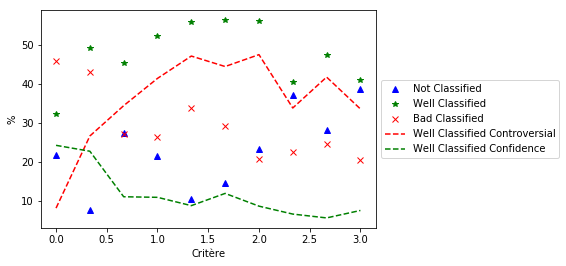

In [52]:
f= 15 #nb of folds
list_critere= np.linspace(0, 3, num=10) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)


################################################################################################################################

list_not_classified=[];
list_well_classified=[];
list_well_classified_controversial=[]
list_well_classified_confidence=[]
list_bad_classified=[];

file='light_graph_1_week_20180623_to_20180630_critere_10.gexf'
G=nx.read_gexf(file)
G=normalization_graph(G);

pbar = tqdm(total=len(list_critere)*f)

for critere in list_critere:
    mean_not_classified=0
    mean_well_classified=0
    mean_bad_classified=0
    mean_well_classified_controversial=0;
    mean_well_classified_confidence=0;

    for i in range (0,f):
        #print('f=',i,'et critere=',critere)
        [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)

        mean_not_classified+=not_classified/to_classify
        mean_well_classified_controversial+=well_classified_controversial/to_classify
        mean_well_classified_confidence+=well_classified_confidence/to_classify
        mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
        mean_bad_classified+=bad_classified/to_classify
        
        pbar.update(1)

    list_not_classified.append(100*mean_not_classified/f)
    list_well_classified.append(100*mean_well_classified/f)
    list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
    list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
    list_bad_classified.append(100*mean_bad_classified/f)
    
    
pbar.close()

# plot graph
plt.figure()

plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
plt.xlabel('Critère')
plt.ylabel('%')

plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('light_graph_1_week_20180623_to_20180630_critere_10')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:34<00:00,  6.06it/s]


Text(0.5,1,'light_graph_1_week_20180623_to_20180630_critere_5')

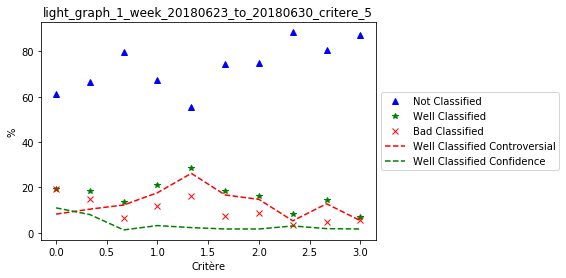

In [53]:
f= 15 #nb of folds
list_critere= np.linspace(0, 3, num=10) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)


################################################################################################################################

list_not_classified=[];
list_well_classified=[];
list_well_classified_controversial=[]
list_well_classified_confidence=[]
list_bad_classified=[];

file='light_graph_1_week_20180623_to_20180630_critere_5.gexf'
G=nx.read_gexf(file)
G=normalization_graph(G);

pbar = tqdm(total=len(list_critere)*f)

for critere in list_critere:
    mean_not_classified=0
    mean_well_classified=0
    mean_bad_classified=0
    mean_well_classified_controversial=0;
    mean_well_classified_confidence=0;

    for i in range (0,f):
        #print('f=',i,'et critere=',critere)
        [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)

        mean_not_classified+=not_classified/to_classify
        mean_well_classified_controversial+=well_classified_controversial/to_classify
        mean_well_classified_confidence+=well_classified_confidence/to_classify
        mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
        mean_bad_classified+=bad_classified/to_classify
        
        pbar.update(1)

    list_not_classified.append(100*mean_not_classified/f)
    list_well_classified.append(100*mean_well_classified/f)
    list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
    list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
    list_bad_classified.append(100*mean_bad_classified/f)
    
    
pbar.close()

# plot graph
plt.figure()

plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
plt.xlabel('Critère')
plt.ylabel('%')

plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('light_graph_1_week_20180623_to_20180630_critere_5')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:59<00:00,  3.02it/s]


Text(0.5,1,'light_graph_1_week_20180623_to_20180630_critere_7')

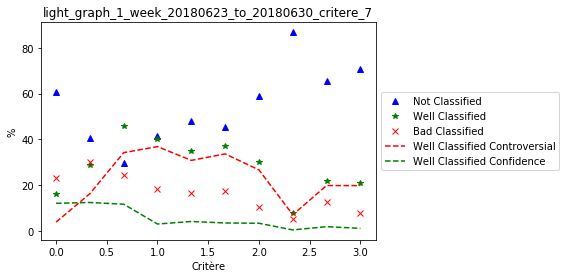

In [56]:
f= 15 #nb of folds
list_critere= np.linspace(0, 3, num=10) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)


################################################################################################################################

list_not_classified=[];
list_well_classified=[];
list_well_classified_controversial=[]
list_well_classified_confidence=[]
list_bad_classified=[];

file='light_graph_1_week_20180623_to_20180630_critere_7.gexf'
G=nx.read_gexf(file)
G=normalization_graph(G);

pbar = tqdm(total=len(list_critere)*f)

for critere in list_critere:
    mean_not_classified=0
    mean_well_classified=0
    mean_bad_classified=0
    mean_well_classified_controversial=0;
    mean_well_classified_confidence=0;

    for i in range (0,f):
        #print('f=',i,'et critere=',critere)
        [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)

        mean_not_classified+=not_classified/to_classify
        mean_well_classified_controversial+=well_classified_controversial/to_classify
        mean_well_classified_confidence+=well_classified_confidence/to_classify
        mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
        mean_bad_classified+=bad_classified/to_classify
        
        pbar.update(1)

    list_not_classified.append(100*mean_not_classified/f)
    list_well_classified.append(100*mean_well_classified/f)
    list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
    list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
    list_bad_classified.append(100*mean_bad_classified/f)
    
    
pbar.close()

# plot graph
plt.figure()

plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
plt.xlabel('Critère')
plt.ylabel('%')

plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('light_graph_1_week_20180623_to_20180630_critere_7')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.52it/s]


Text(0.5,1,'light_graph_1_week_20180623_to_20180630_critere_entre_5_et_10')

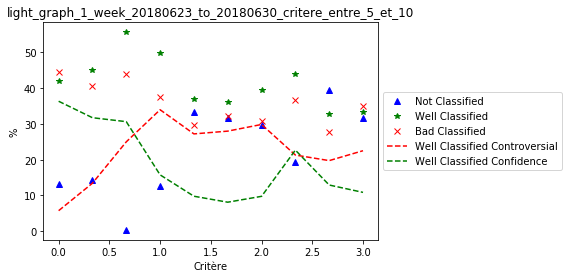

In [63]:
f= 15 #nb of folds
list_critere= np.linspace(0, 3, num=10) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)


################################################################################################################################

list_not_classified=[];
list_well_classified=[];
list_well_classified_controversial=[]
list_well_classified_confidence=[]
list_bad_classified=[];

file='light_graph_1_week_20180623_to_20180630_critere_between_5_10.gexf'
G=nx.read_gexf(file)
G=normalization_graph(G);

pbar = tqdm(total=len(list_critere)*f)

for critere in list_critere:
    mean_not_classified=0
    mean_well_classified=0
    mean_bad_classified=0
    mean_well_classified_controversial=0;
    mean_well_classified_confidence=0;

    for i in range (0,f):
        #print('f=',i,'et critere=',critere)
        [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)

        mean_not_classified+=not_classified/to_classify
        mean_well_classified_controversial+=well_classified_controversial/to_classify
        mean_well_classified_confidence+=well_classified_confidence/to_classify
        mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
        mean_bad_classified+=bad_classified/to_classify
        
        pbar.update(1)

    list_not_classified.append(100*mean_not_classified/f)
    list_well_classified.append(100*mean_well_classified/f)
    list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
    list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
    list_bad_classified.append(100*mean_bad_classified/f)
    
    
pbar.close()

# plot graph
plt.figure()

plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
plt.xlabel('Critère')
plt.ylabel('%')

plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('light_graph_1_week_20180623_to_20180630_critere_entre_5_et_10')

 Conclusion
     <5 : pas d'informations permettant label propagation
     <7 : début d'information, mais pas encore ça
     <10 : assez d'information
     
 => L'information permettant la propagation du label est contenu dans les évenement peut partagés (environ <10), mais pas dans les évenement les moins partagés (<5 ne donne pas de résultats)
 
 Entre 5 et 10 : ca marche moyen -> l'information semble disséminée parmis les events publiés entre 1 (non compris) et 10
     

### Study dissemination over "layout"

    Start between 1 et 10
    then 2 and 10 ...
    and 5 et 10
    
    -> Steep curve: not well distributed
    -> Smooth curve: well distributed

In [8]:
# Préprocessing : we remove from the dataframe anything above 10
all_data_path='1_week_all_data_preprocess.csv'
data=open_data(all_data_path)
all_data_preprocess=data[data.groupby('GlobalEventID').GlobalEventID.transform(len) < 10]
all_data_preprocess.to_csv('1_week_all_data_preprocess_1_10.csv',sep = '\t',decimal = '.')

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
#creating the graphs (1-10 and 5-10 already done)
all_data_preprocess_path='1_week_all_data_preprocess_1_10.csv'
critere_sup=10
for i in [2, 3, 4]:
    critere_inf=i
    G=light_graph_sources_poids_v3(all_data_preprocess_path,critere_sup,critere_inf)
    G_clean=cleaning_graph(G);
    nx.write_gexf(G_clean,'light_graph_1_week_20180623_to_20180630_critere_between_'+str(critere_inf)+'_10.gexf')
    print(str(i)+'ème graph OK')

C:\Users\maell\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|█████████████████████████████████████████████████████████████████████████| 320668/320668 [10:06<00:00, 528.85it/s]


2ème graph OK


100%|█████████████████████████████████████████████████████████████████████████| 320668/320668 [08:23<00:00, 636.71it/s]


3ème graph OK


100%|█████████████████████████████████████████████████████████████████████████| 320668/320668 [09:58<00:00, 535.77it/s]


4ème graph OK


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [05:49<00:00,  3.44it/s]


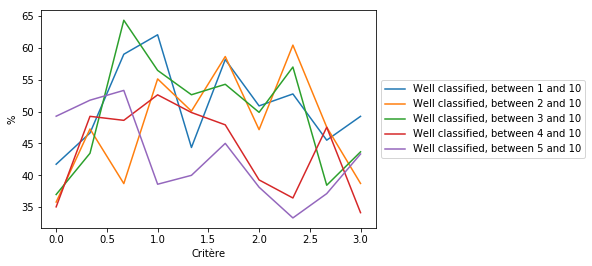

In [8]:
# comparing results

f= 15 #nb of folds
list_critere= np.linspace(0, 3, num=10) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)


################################################################################################################################



file='light_graph_1_week_20180623_to_20180630_critere_between_5_10.gexf'
G=nx.read_gexf(file)
G=normalization_graph(G);

pbar = tqdm(total=len(list_critere)*f*5)

list_path=['light_graph_1_week_20180623_to_20180630_critere_10.gexf',
           'light_graph_1_week_20180623_to_20180630_critere_between_2_10.gexf',
           'light_graph_1_week_20180623_to_20180630_critere_between_3_10.gexf',
           'light_graph_1_week_20180623_to_20180630_critere_between_4_10.gexf',
           'light_graph_1_week_20180623_to_20180630_critere_between_5_10.gexf']

list_label=['Well classified, between 1 and 10',
           'Well classified, between 2 and 10',
           'Well classified, between 3 and 10',
           'Well classified, between 4 and 10',
           'Well classified, between 5 and 10']

for j in range (0,5):
    G=nx.read_gexf(list_path[j])
    G=normalization_graph(G);
    list_well_classified=[];
    for critere in list_critere:
        mean_well_classified=0
        for i in range (0,f):
            #print('f=',i,'et critere=',critere)
            [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)
            mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
            pbar.update(1)

        list_well_classified.append(100*mean_well_classified/f)
    plt.plot(list_critere, list_well_classified,label=list_label[j])

pbar.close()
plt.xlabel('Critère')
plt.ylabel('%')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The information allowing classification is fairly well distributed within the "layers" of many publications: the fewer layers there are, the less good the classification.  
However, we can notice that the graph constructed between 3 and 10 has a very good performance which is even better than for the graph constructed between 1 and 10: the information contained between 3 and 10 is therefore more relevant (for this week in particular)!